In [1]:
import os # for file handling
import pathlib # for reading files
import pandas as pd # for reading csv files
import numpy as np # for numerical operations
from PIL import Image # for opening images
import shutil # for moving files
import matplotlib.pyplot as plt # for plotting

import tensorflow as tf # for deep learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall
from tensorflow.keras.regularizers import l2

Check GPU

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

TensorFlow version: 2.10.1
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']


## Load Data using Keras utility

In [3]:
data_dir = pathlib.Path('C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\cats_hrs_training_2024_06_06\\training')

We have 3 cats but recently a fourth cat is showing up. Since we have only few imaes of this cat let's ignore this for now and train only for our own 3 cats.

Define parameters for loader

In [4]:
batch_size = 32
#Larger batches also provide a more accurate estimate of the gradient, but they require more memory.
#Smaller batches are more useful for real-time applications where the model needs to make a prediction for a single instance at a time.

img_height = 180 # Using the actual sizes takes too long for training and makes the model too large for Raspberry Pi
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3540 files belonging to 3 classes.
Using 2832 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3540 files belonging to 3 classes.
Using 708 files for validation.


By default, if label_mode is not specified, it is set to "int", which means the function automatically assigns an integer label to each class. Classes are usually indexed according to the alphanumeric order of the folder names. Therefore, each image is labeled with the integer representing its class index.

'h' -> 0

'o' -> 1

'r' -> 2

's' -> 3

SparseCategoricalCrossentropy the appropriate choice for the loss function because it expects the labels to be provided as integers

You can find the class names in the `class_names` attribute on these datasets.

In [7]:
class_names = train_ds.class_names
print(class_names)

['h', 'r', 's']


## visualize the Data

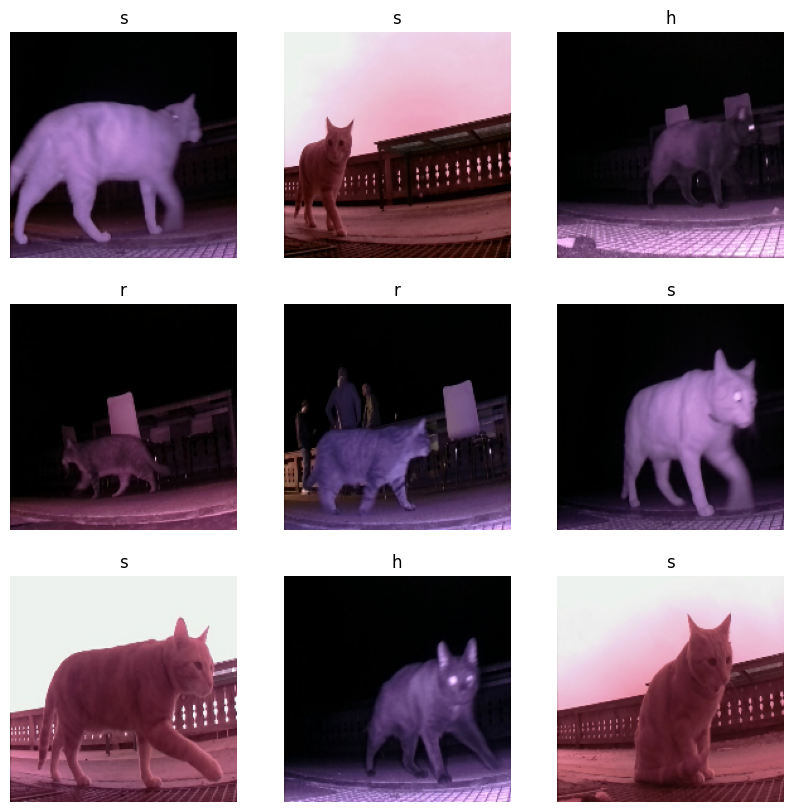

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


An image can be represented as a 3-D tensor. For a color image, the dimensions might correspond to height, width, and color channels (RGB). The `image_batch` is a tensor of the shape `(32, 480, 640, 3)`. This is a batch of 32 images of shape `480x640x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the Data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [11]:
# not neccessary if it is included as the first layer in the model
# normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [12]:
'''
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''

'\nnormalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n# Notice the pixel values are now in `[0,1]`.\nprint(np.min(first_image), np.max(first_image))\n'

Or, you can include the layer inside your model definition to simplify deployment. Use the second approach here.

# A basic Keras model

The `softmax` function is particularly suited for multi-class classification problems where each class is mutually exclusive.

When using `softmax`, set `from_logits=False`

When not using `softmax` (last layer outputs raw scores), set `from_logits=True` 

### Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [13]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

'''
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
  layers.Dense(num_classes, activation='softmax') # Using softmax for probability output
])
'''
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Number of classes: 3


The Rescaling layer only handles the normalization of pixel values. It does not perform resizing. The input_shape parameter in the Rescaling layer simply specifies the expected input dimensions for the model, but it does not automatically resize images to those dimensions.

Padding = same

Enhanced Edge Learning: In the context of cat images, distinguishing features such as the tips of ears, whiskers, or patterns on the fur near the edges could be crucial for accurate classification. Padding ensures that convolutions applied to the edges of an image don't shrink the spatial dimension, thus better preserving the information at the edges.

Consider a scenario where your images of cats vary slightly in where the cats are positioned within the image frame. Without appropriate padding, important features at the edges might get progressively omitted in deeper layers, potentially leading to poorer model performance, especially if those edge features are critical for distinguishing between similar cat breeds.

### Compile the model

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [14]:
# set from_logits=True if the model does not include a softmax activation
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

When using `from_logits=True` the last layer should not apply softmax (it outputs raw scores)
When using `from_logits=False`, the last layer should apply softmax to output probabilities.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train model

In [16]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
89/89 [==============================] - 2s 9ms/step - loss: 0.7856 - accuracy: 0.6670 - val_loss: 0.5559 - val_accuracy: 0.8065
Epoch 2/30
89/89 [==============================] - 1s 6ms/step - loss: 0.3761 - accuracy: 0.8658 - val_loss: 0.3243 - val_accuracy: 0.8715
Epoch 3/30
89/89 [==============================] - 1s 6ms/step - loss: 0.1871 - accuracy: 0.9340 - val_loss: 0.3063 - val_accuracy: 0.8856
Epoch 4/30
89/89 [==============================] - 1s 6ms/step - loss: 0.1049 - accuracy: 0.9629 - val_loss: 0.2290 - val_accuracy: 0.9251
Epoch 5/30
89/89 [==============================] - 1s 6ms/step - loss: 0.0552 - accuracy: 0.9806 - val_loss: 0.2833 - val_accuracy: 0.9153
Epoch 6/30
89/89 [==============================] - 1s 6ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.2812 - val_accuracy: 0.9181
Epoch 7/30
89/89 [==============================] - 1s 6ms/step - loss: 0.0468 - accuracy: 0.9823 - val_loss: 0.3491 - val_accuracy: 0.8828
Epoch 8/30
89/89 [==

## Visualize training results

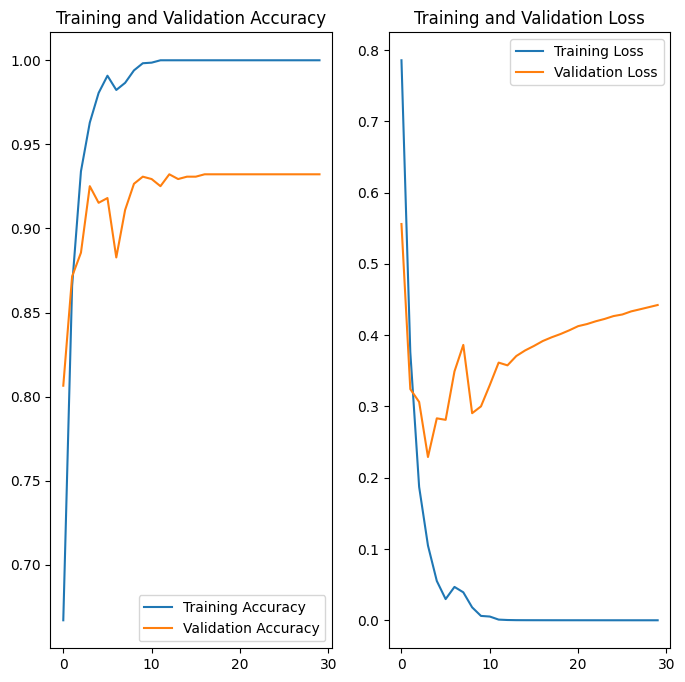

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Total overfit! The plots show that training accuracy and validation accuracy are off by large margins.

# Overfitting

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

visualize examples of augmentation

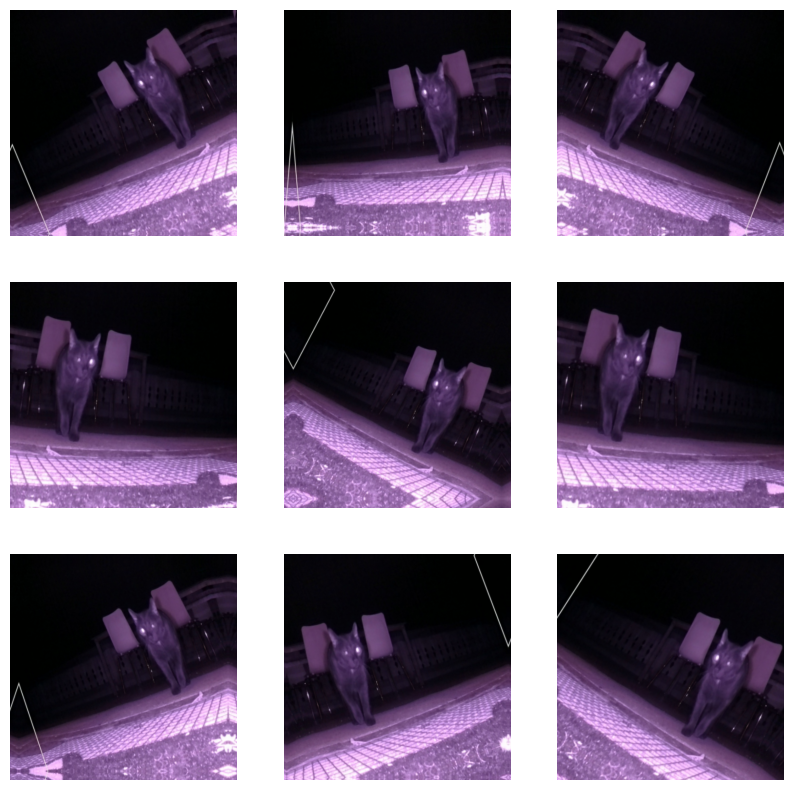

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 480, 480, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 480, 480, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 240, 240, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 240, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                  

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
89/89 [==============================] - 14s 154ms/step - loss: 0.6975 - accuracy: 0.7062 - val_loss: 0.6489 - val_accuracy: 0.6822
Epoch 2/30
89/89 [==============================] - 16s 182ms/step - loss: 0.6000 - accuracy: 0.7401 - val_loss: 0.5350 - val_accuracy: 0.7853
Epoch 3/30
89/89 [==============================] - 15s 169ms/step - loss: 0.5101 - accuracy: 0.7835 - val_loss: 0.4735 - val_accuracy: 0.7881
Epoch 4/30
89/89 [==============================] - 15s 165ms/step - loss: 0.4627 - accuracy: 0.8111 - val_loss: 0.4842 - val_accuracy: 0.8051
Epoch 5/30
89/89 [==============================] - 16s 175ms/step - loss: 0.4317 - accuracy: 0.8263 - val_loss: 0.4393 - val_accuracy: 0.8206
Epoch 6/30
89/89 [==============================] - 18s 198ms/step - loss: 0.3814 - accuracy: 0.8390 - val_loss: 0.3866 - val_accuracy: 0.8305
Epoch 7/30
89/89 [==============================] - 16s 182ms/step - loss: 0.3664 - accuracy: 0.8453 - val_loss: 0.3869 - val_accuracy: 0.8418

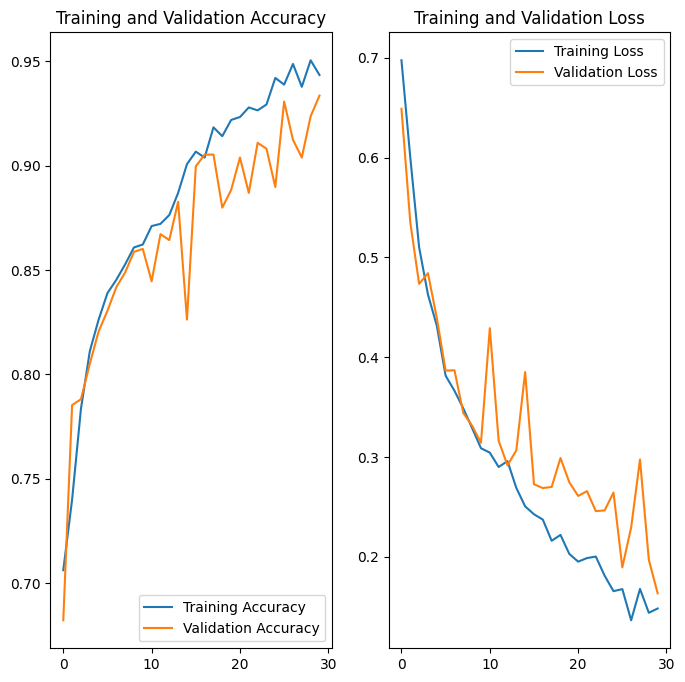

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This looks already much better. Let's further fine-tune hyperparameters

# Further Improvements

In [11]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255), # input shape already defined in data_augmentation layer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes) #activation='softmax'
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Use 'sparse_categorical_crossentropy' if labels are integers
  metrics='accuracy')
# try from_logits=True if the model does not include an activation function in the last layer
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

In [12]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
89/89 [==============================] - 11s 95ms/step - loss: 2.5115 - accuracy: 0.5367 - val_loss: 1.1357 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 2/500
89/89 [==============================] - 8s 95ms/step - loss: 0.9293 - accuracy: 0.6706 - val_loss: 0.9137 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 3/500
89/89 [==============================] - 9s 102ms/step - loss: 0.8382 - accuracy: 0.7126 - val_loss: 0.7978 - val_accuracy: 0.7161 - lr: 0.0010
Epoch 4/500
89/89 [==============================] - 9s 100ms/step - loss: 0.8041 - accuracy: 0.7429 - val_loss: 0.8120 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 5/500
89/89 [==============================] - 9s 101ms/step - loss: 0.7798 - accuracy: 0.7429 - val_loss: 0.7767 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 6/500
89/89 [==============================] - 9s 105ms/step - loss: 0.7695 - accuracy: 0.7585 - val_loss: 0.7022 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 7/500
89/89 [==============================] - 9s 101ms/ste

33 min for 135 epochs

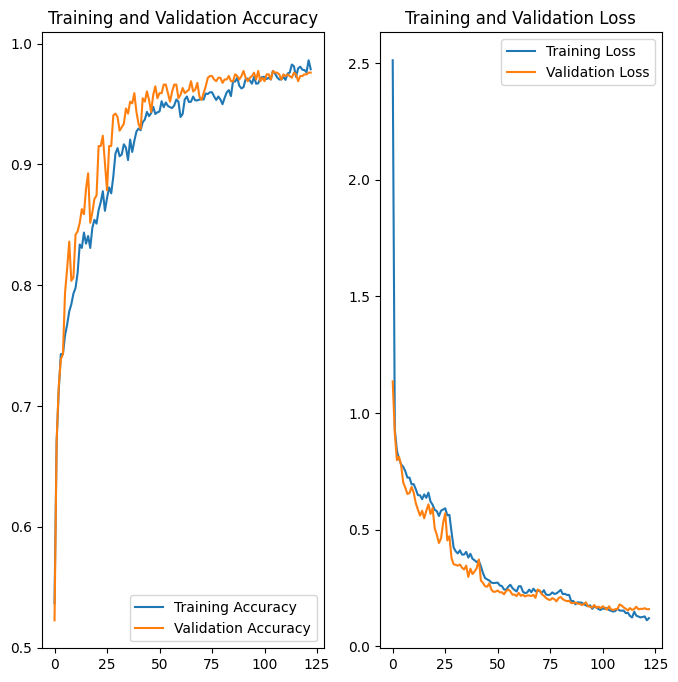

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(123) # adjust this based on the number of epochs trained for (to avoid value error)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()